1 Physical GPUs, 1 Logical GPU
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Model: "MobileNetV2_FineTuned"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                           

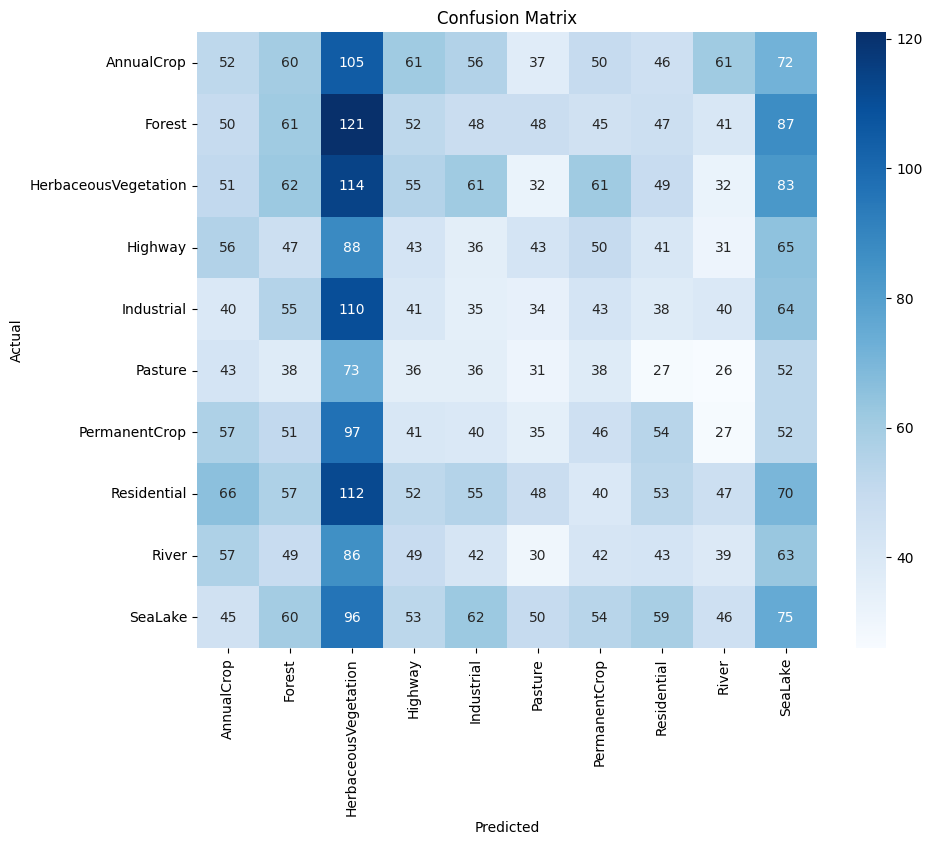

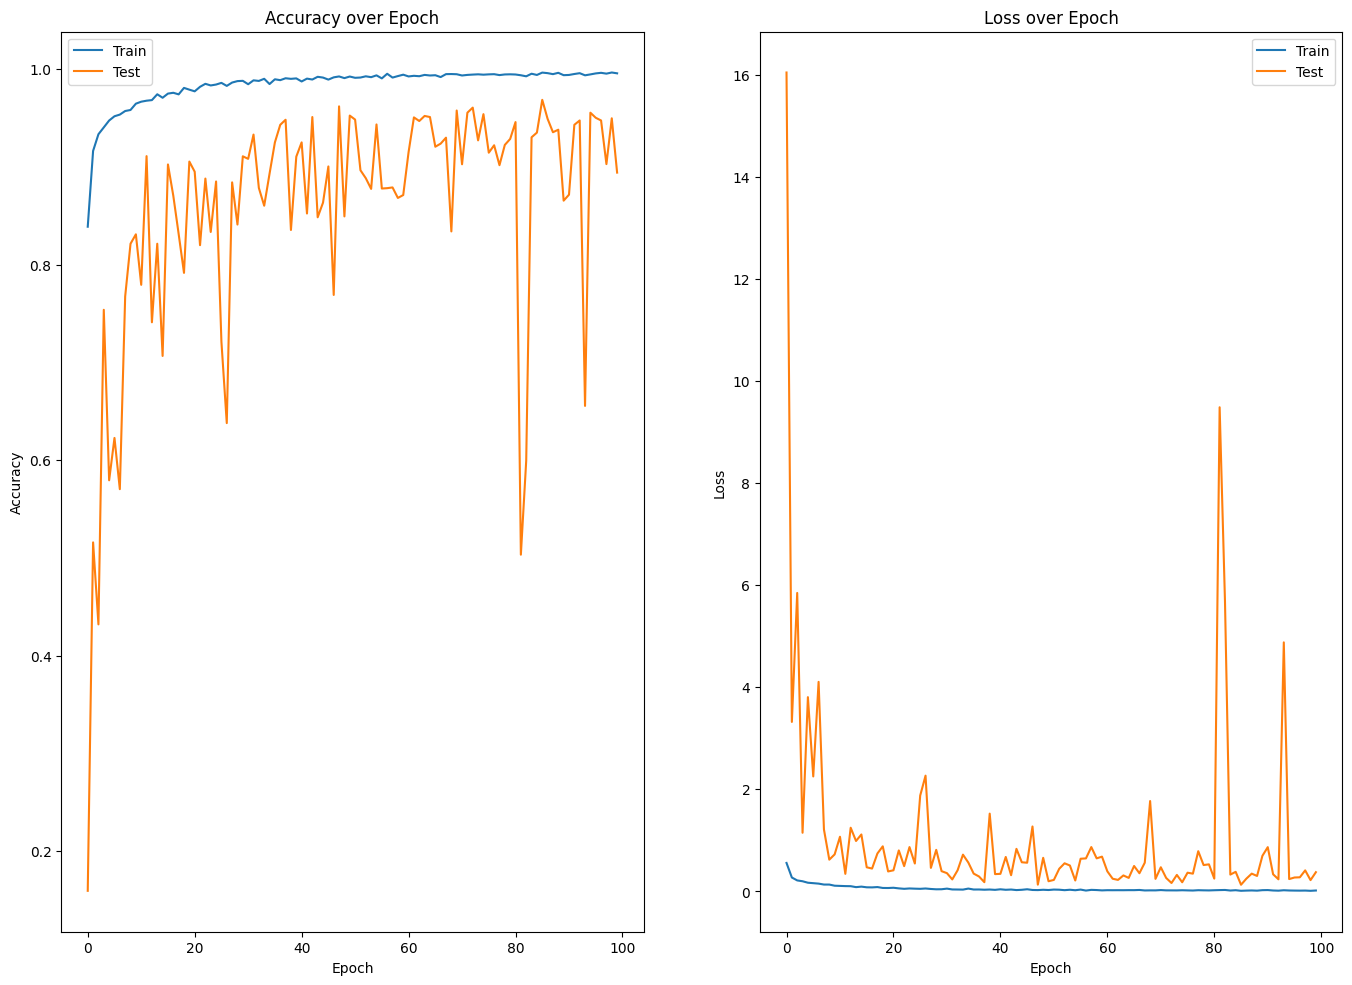

In [7]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

# Data paths and parameters
dataset_url = "/kaggle/input/eurosat10-classes/EuroSAT_RGB"
batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0 / 255

# Data augmentation
datagen = ImageDataGenerator(validation_split=validation_split, rescale=rescale)

# Load datasets with one-hot encoding
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                            directory=dataset_url,
                                            shuffle=True,
                                            target_size=(img_height, img_width),
                                            subset="training",
                                            class_mode='categorical')
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

# Updated MobileNetV2Model function
def MobileNetV2Model(input_shape=(64, 64, 3), classes=10):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers[-20:]:  # Fine-tune the last 20 layers
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x, name='MobileNetV2_FineTuned')
    return model

# Train the model
model = MobileNetV2Model(input_shape=(img_height, img_width, 3), classes=10)
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0011), loss='categorical_crossentropy', metrics=['accuracy'])

# Train for more epochs
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=32)

# Evaluate the model
_, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predictions on the test dataset
y_pred = model.predict(test_dataset).argmax(axis=1)
y_true = test_dataset.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
class_labels = list(train_dataset.class_indices.keys())
classification_rep = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", classification_rep)

# Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Weighted Precision: {precision * 100:.2f}%, Weighted Recall: {recall * 100:.2f}%, Weighted F1-score: {f1 * 100:.2f}%')

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(cm, classes=class_labels)

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy over Epoch')
    ax1.legend(['Train', 'Test'], loc="upper left")

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss over Epoch')
    ax2.legend(['Train', 'Test'], loc="upper right")

    plt.show()

# Plot training history
plot_training_history(history)
